In [1]:
cd ..

/home/ubuntu/Facial_key_point


## Import Packages

In [2]:
# inbuilt packages 
import os 
from PIL import Image
from tqdm import tqdm 

# Datascience Packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

# PyTorch Related Packages 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision import models

## Hyper Parameters

In [3]:
batch_size = 512
model_input_size = 224
n_epoch = 10
learning_rate = 0.0001

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## DataLoader

In [6]:
class FaceKeyPointData(Dataset):
    def __init__(self, csv_path='data/training_frames_keypoints.csv', split='training', device=torch.device('cpu')):
        super(FaceKeyPointData).__init__()
        self.csv_path = csv_path
        self.split = split
        self.df = pd.read_csv(self.csv_path)
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        self.device = device

    def __len__(self):
        return len(self.df) 

    def __getitem__(self, index):
        img, original_size = self.get_img(index) 
        key_points = self.get_keypoints(index=index, original_size= original_size)
        return img, key_points
    
    def get_img(self, index):
        img_path = os.path.join(os.getcwd(), 'data', self.split, self.df.iloc[index,0])
        img = Image.open(img_path).convert('RGB')
        original_size = img.size 

        # preprocess Image
        img = img.resize((model_input_size, model_input_size))
        img = np.asarray(img) / 255.0
        img = torch.tensor(img).permute(2, 0 , 1)
        img = self.normalize(img).float()
        return img.to(self.device), original_size
    
    def get_keypoints(self, index, original_size):
        kp = self.df.iloc[index, 1:].to_numpy().astype(np.float32)
        kp_x = kp[0::2] / original_size[0]
        kp_y = kp[1::2] / original_size[1]
        kp = np.concatenate([kp_x, kp_y])
        return torch.tensor(kp).to(self.device)

    def load_img(self, index):
        img_path = os.path.join(os.getcwd(), 'data', self.split, self.df.iloc[index,0])
        img = Image.open(img_path).convert('RGB')
        img = img.resize((model_input_size, model_input_size))
        return np.asarray(img) / 255.0


training_data = FaceKeyPointData(device=device)
test_data = FaceKeyPointData(csv_path='data/test_frames_keypoints.csv', split='test', device=device)

In [7]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:

batch_img, batch_key_points = next(iter(train_dataloader))
batch_img.shape

torch.Size([512, 3, 224, 224])

In [9]:
batch_key_points.shape

torch.Size([512, 136])

## Data Visualization

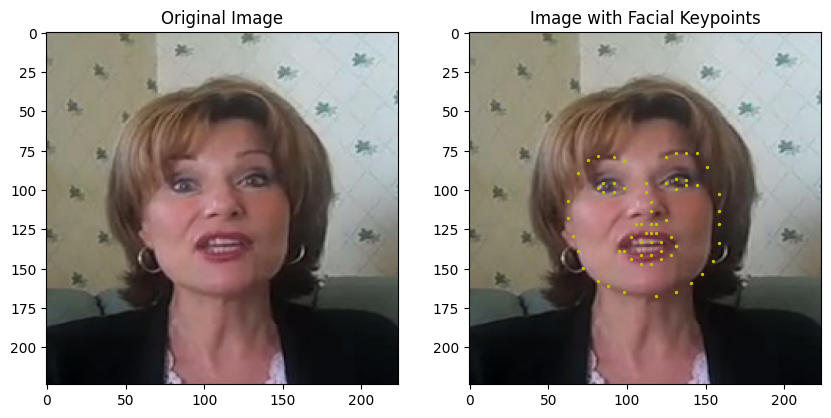

In [10]:
img_index = 11
img = training_data.load_img(img_index)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(122)
plt.title("Image with Facial Keypoints")
plt.imshow(img)

img_tensor, kp_s = training_data[img_index]
kp_s = kp_s.to('cpu')
plt.scatter(kp_s[:68] * model_input_size, kp_s[68:] * model_input_size, c='y',s = 2)

## Model Building 

In [11]:
def get_model(device):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for layers in model.parameters():
        layers.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, 3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid()
    )
    return model.to(device=device)
model = get_model(device=device)

In [12]:
criterion = nn.L1Loss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [13]:
def train_batch(imgs, kps, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    # forward Pass
    kps_pred = model(imgs)
    loss = criterion(kps_pred, kps)

    # backward Pass
    loss.backward()
    optimizer.step()

    return loss 

In [14]:
@torch.no_grad()
def validation_batch(imgs, kps, model, criterion):
    model.eval()

    kps_pred = model(imgs)
    loss = criterion(kps_pred, kps)
    return loss


## Training Pipeline

In [15]:
train_loss = []
test_loss = []

for epoch in range(1, n_epoch+1):
    epoch_train_loss, epoch_test_loss = 0, 0 

    # train 
    for images, kps in tqdm(train_dataloader, desc=f'Training {epoch} of {n_epoch}'):
        # images, kps = 
        loss = train_batch(images, kps, model, criterion, optimizer)
        epoch_train_loss+= loss.item()
    epoch_train_loss /= len(train_dataloader)
    train_loss.append(epoch_train_loss)
   
    # validation
    for images, kps in tqdm(test_dataloader, desc="validation"):
        loss = validation_batch(images, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= len(test_dataloader)
    test_loss.append(epoch_test_loss)

    print(f"Epoch {epoch} of {n_epoch}: Training Loss: {epoch_train_loss}, Test Loss: {epoch_test_loss}")

validation: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Epoch 1 of 10: Training Loss: 0.08421084071908679, Test Loss: 0.055853117257356644


validation: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Epoch 2 of 10: Training Loss: 0.06857062131166458, Test Loss: 0.04924990423023701


validation: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


Epoch 3 of 10: Training Loss: 0.06210840706314359, Test Loss: 0.04403420351445675


validation: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


Epoch 4 of 10: Training Loss: 0.05757350687469755, Test Loss: 0.04089881107211113


validation: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


Epoch 5 of 10: Training Loss: 0.053706486842461994, Test Loss: 0.03836376965045929


validation: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


Epoch 6 of 10: Training Loss: 0.05065481524382319, Test Loss: 0.03640690818428993


validation: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


Epoch 7 of 10: Training Loss: 0.04799866569893701, Test Loss: 0.0340132936835289


validation: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Epoch 8 of 10: Training Loss: 0.045562975640807836, Test Loss: 0.03185056708753109


Training 9 of 10:  43%|████▎     | 3/7 [00:10<00:14,  3.62s/it]


KeyboardInterrupt: 

## Train and Test Loss Curve

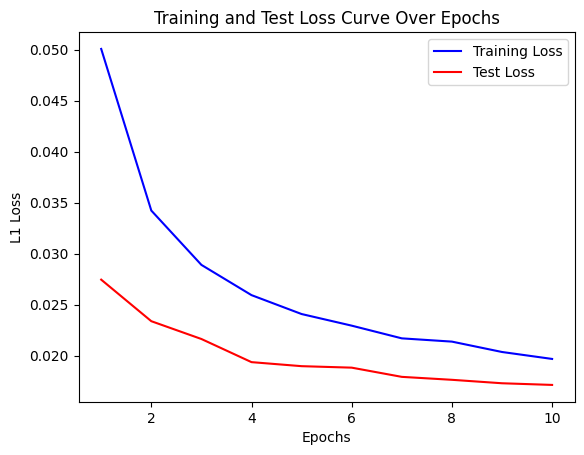

In [15]:
epochs = np.arange(1, n_epoch+1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'r', label='Test Loss')
plt.title("Training and Test Loss Curve Over Epochs")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()
plt.show()

## Result visualization

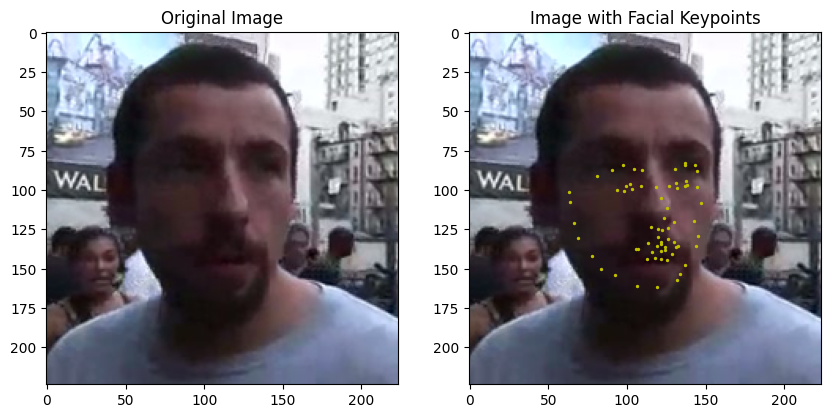

In [16]:
img_index = 11
img = test_data.load_img(img_index)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(122)
plt.title("Image with Facial Keypoints")
plt.imshow(img)

img, _ = test_data[img_index]
kp_s = model(img[None]).flatten().detach().cpu()
kp_s = kp_s.to('cpu')
plt.scatter(kp_s[:68] * model_input_size, kp_s[68:] * model_input_size, c='y',s = 2)